In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras import layers 
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import Image,display 
import matplotlib.cm as cm

In [3]:
generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [4]:
train_dataset = generator.flow_from_directory(batch_size=32,
                                                 directory='./cell_images/',
                                                 shuffle=True,
                                                    target_size=(44, 44),
                                                  subset="training", 
                                                  class_mode='categorical')

test_dataset = generator.flow_from_directory(batch_size=32,
                                                 directory='./cell_images/',
                                                 shuffle=True,
                                                 target_size=(44, 44),
                                                 subset="validation",
                                                 class_mode='categorical')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


# Build Model

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(44, 44, 3)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(512, kernel_size=(3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(2, activation="softmax"),
    ]
)

In [ ]:
model.summary()

In [ ]:
opt = keras.optimizers.SGD(learning_rate=0.002, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [ ]:
history = model.fit_generator(
    train_dataset,
    steps_per_epoch = train_dataset.samples // 64,
    validation_data = test_dataset, 
    validation_steps = test_dataset.samples // 64,
    epochs = 10)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['loss', 'val_loss'])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['accuracy','val_accuracy'])

# Activation Visualization

In [ ]:
    image_size = (64, 64)

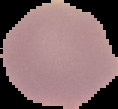

In [39]:
display(Image('1.png'))

In [62]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Predicted: [[-2818.5696  2191.6365]]


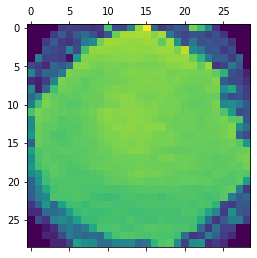

In [63]:
# Prepare image
img_array = get_img_array("1.png", size=image_size)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_5')

# Display heatmap
plt.matshow(heatmap)
plt.show()

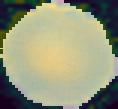

In [172]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("viridis")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam('1.png', heatmap)

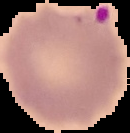

In [173]:
display(Image('3.png'))

Predicted: [[-3152.2307  2186.759 ]]


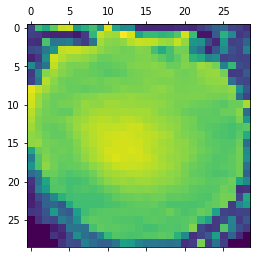

In [174]:
# Prepare image
img_array = get_img_array("3.png", size=image_size)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_5')

# Display heatmap
plt.matshow(heatmap)
plt.show()

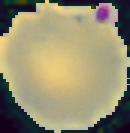

In [175]:
heatmap = make_gradcam_heatmap(img_array, model, 'conv2d_5')
save_and_display_gradcam('3.png', heatmap)

# Activation Layer

In [75]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot

In [88]:
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 conv2d_4 (None, 62, 62, 32)
3 conv2d_5 (None, 29, 29, 64)
6 conv2d_6 (None, 12, 12, 128)
9 conv2d_7 (None, 4, 4, 256)


In [176]:
def show_feature_map(model, img_path, img_size=(64,64), square=5):
    ixs = [0, 3, 6, 9]
    outputs = [model.layers[i].output for i in ixs]
    model = keras.Model(inputs=model.inputs, outputs=outputs)

    # load the image with the required shape
    img = load_img(img_path, target_size=img_size)

    # convert the image to an array
    img = img_to_array(img)

    # expand dimensions so that it represents a single 'sample'
    img = np.expand_dims(img, axis=0)

    # get feature map for first hidden layer
    feature_maps = model.predict(img)

    # plot the output from each block
    for fmap in feature_maps:
        ix = 1
        for _ in range(square):
            for _ in range(square):
                # specify subplot and turn of axis
                ax = pyplot.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                pyplot.imshow(fmap[0, :, :, ix-1], cmap='viridis')
                ix += 1
        # show the figure
        pyplot.show()

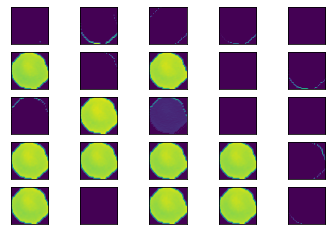

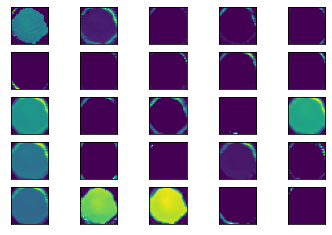

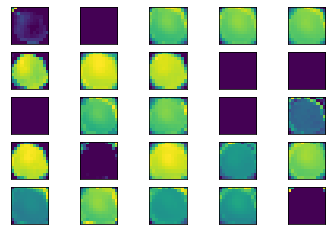

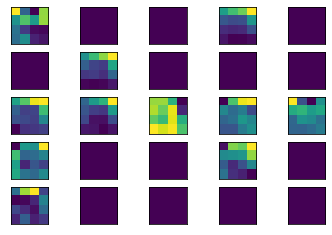

In [177]:
show_feature_map(model, '1.png')

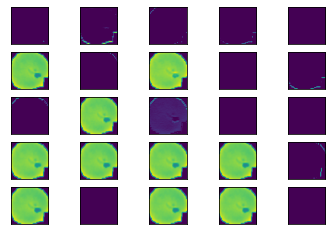

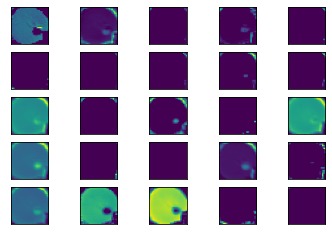

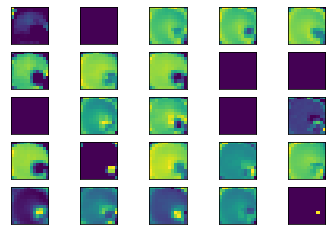

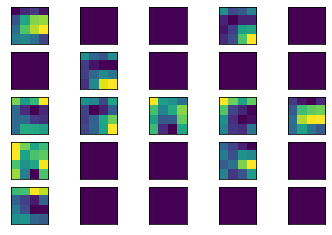

In [178]:
show_feature_map(model, '2.png')